In [1]:
import pandas as pd
import numpy as np
import requests
import json
import datetime
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LassoLarsCV
from sklearn.svm import LinearSVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import xgboost as xgb

# Download 2016 ACS 5YR County Level Data
Query data from BigQuery. Dataset was created using this script library https://github.com/jbencina/analytics-projects/tree/master/census-acs-data. Instead of using the 1YR data however, I reran it for the 5YR to get additional counties in the results

In [2]:
def get_acs_data(bq_key_path, bq_project_id):
    file_name = 'data_cache/2016_acs_5yr_by_county.csv'
    
    if os.path.exists(file_name):
        print('Read from disk')
        return pd.read_csv(file_name)
    
    query = """
        #standardSQL
        SELECT
            *
        FROM `jbencina-144002.census.acs_2016_5yr_county`
            """
    
    data_bq = pd.read_gbq(query, private_key=bq_key_path, project_id=bq_project_id, dialect='standard')
    
    data_bq.Id = data_bq.Id.str[-5:]
    data_bq = data_bq.drop(['HHWithComputer','HHWithBroadband'], axis=1) # Not available in current 5YR release
    data_bq = data_bq.rename(columns={'Id': 'fips'})
    data_bq.to_csv(file_name, index=False, encoding='utf-8')
    return data_bq

data_acs = get_acs_data('../bq-python.json', 'jbencina-144002')
data_acs.head()

Read from disk


,fips,Label,TotalHH,FamilyHH,HHWithUnder18,HHWith65Plus,AvgHHSize,EnrollmentPreK,EnrollmentK,EnrollmentElem,...,Age85Plus,AgeMedian,RaceWhite,RaceBlack,RaceNative,RaceAsian,RacePacific,RaceOther,RaceMixed,PopHispanic
0,51510,"Alexandria city, Virginia",68063.0,48.5,22.8,16.6,2.20,8.6,4.5,34.7,...,1.2,36.2,62.7,21.6,0.2,6.5,0.0,4.1,4.9,16.7
1,26161,"Washtenaw County, Michigan",138672.0,57.8,27.0,22.3,2.44,4.0,2.8,25.1,...,1.5,33.4,74.0,12.0,0.3,8.5,0.0,0.9,4.3,4.4
2,51013,"Arlington County, Virginia",100707.0,46.6,22.4,15.5,2.21,9.2,5.5,31.5,...,1.3,34.1,72.2,8.6,0.4,10.0,0.1,5.6,3.1,15.4
3,53033,"King County, Washington",831995.0,59.7,29.1,21.7,2.46,7.1,5.0,38.3,...,1.8,37.2,67.2,6.2,0.7,16.0,0.8,3.1,6.1,9.3
4,2016,"Aleutians West Census Area, Alaska",1186.0,58.8,35.9,11.8,3.47,9.1,7.8,46.0,...,0.2,37.6,30.9,5.5,13.0,36.5,2.5,6.1,5.5,13.8


# Download Alabama Race Results
Using Chrome debugger, I was able to to find the URL which generates the JSON data populating the map. I download this as a JSON file and cache it locally. Minor calculations are performed to calculate the percentages and the resulting spread.

In [3]:
def get_nyt_alabama_results():
    file_name = 'data_cache/2016_nyt_alabama_by_county.csv'
    
    if os.path.exists(file_name):
        print('Read from disk')
        return pd.read_csv(file_name)[['fips','spread_moore']]
    
    nyt_data = requests.get('https://int.nyt.com/data/sendoff/eln_2017_prd_2017-12-12')
    scrape_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    with open('json_cache/nyt_cached_{}.json'.format(scrape_time), 'w') as f:
        json.dump(nyt_data.json(), f)
            
    file = glob.glob('json_cache/nyt_cached*.json')[-1]
    with open(file, 'r') as f:
        nyt_data = json.load(f)
        
        
    votes = pd.DataFrame.from_dict(nyt_data['contents']['races'][0]['counties'])
    votes['jones'] = votes.results.apply(lambda x: x['jonesd'])
    votes['moore'] = votes.results.apply(lambda x: x['moorer'])

    votes['jones_pct'] = votes.jones/votes.votes
    votes['moore_pct'] = votes.moore/votes.votes
    votes['spread_moore'] = votes.moore_pct - votes.jones_pct

    votes = votes.drop(['results'], axis=1)
    votes.to_csv(file_name, index=False, encoding='utf-8')
    votes = votes[['fips','spread_moore']]
    
    return votes

data_alabama = get_nyt_alabama_results()
data_alabama.head()

Read from disk


,fips,spread_moore
0,1001,0.215317
1,1003,0.261967
2,1005,-0.152804
3,1007,0.388379
4,1009,0.648740


# Download 2016 General Election County Results
Source from Washtington Post elections page. Similarly, I found the request that produces the JSON data used to build the map. I cache the data and perform some transformations on it. This one requires more work because they only had the vote counts by county, not percentages

In [4]:
def get_wp_election_results():
    file_name = 'data_cache/2016_wp_election_by_county.csv'
    
    if os.path.exists(file_name):
        print('Read from disk')
        return pd.read_csv(file_name)
    else:
        wp_data = requests.get('https://dohdeick6sqa6.cloudfront.net/api/v2/metadata/aggregates/president/all-reporting-units.json')
        scrape_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

        with open('json_cache/wp_cached_{}.json'.format(scrape_time), 'w') as f:
            json.dump(wp_data.json(), f)

        file = glob.glob('json_cache/wp_cached*.json')[-1]

        with open(file, 'r') as f:
            wp_data = json.load(f)
            
    results = []

    # Iterate and pull out the relevant elements
    for state in wp_data:
        for component in state['reportingUnits']:
            if component['level'] == 'FIPSCode':
                for candidate in component['candidates']:
                    data = {
                        'race': state['raceType'],
                        'office': state['officeName'],
                        'level': component['level'],
                        'reportingUnit': component['reportingUnitUID'],
                        'candidate': '{} {}'.format(candidate.get('first'), candidate.get('last')),
                        'party': candidate.get('party'),
                        'votes': candidate['voteCount']
                    }
                    results.append(data)
                    
                    
    # Build the data frame and add in a column with the total votes by county
    wp_df = pd.DataFrame(results)
    total_votes = wp_df.groupby('reportingUnit').votes.sum().reset_index().rename(columns={'votes': 'total_votes'})
    wp_df = wp_df.merge(total_votes, on=['reportingUnit'])
    wp_df['pct'] = wp_df.votes / wp_df.total_votes
    wp_df['fips'] = wp_df.reportingUnit.apply(lambda x: x.split('-')[2])
    
    
    
    # Create a pivoted version with just democrat vs gop
    wp_df_pvt = wp_df[wp_df.party.isin(['GOP','Dem'])]
    wp_df_pvt = wp_df_pvt.pivot(index='fips', columns='party', values='pct')
    wp_df_pvt['spread_national_gop'] = wp_df_pvt.GOP - wp_df_pvt.Dem
    wp_df_pvt = wp_df_pvt.reset_index()[['fips','spread_national_gop']]
    wp_df_pvt.to_csv(file_name, index=False, encoding='utf-8')
    
    return wp_df_pvt

data_election = get_wp_election_results()
data_election.head()

Read from disk


,fips,spread_national_gop
0,1001,0.494789
1,1003,0.577862
2,1005,0.056112
3,1007,0.555441
4,1009,0.813820


# Merge into final output
Combine the three datasets into a single table. We will be attempting to use the 2016 presidential results for all states except
Alabama to predict the 2017 Alabama senate race. Alaska and Hawaii are removed because of some missing links when trying to align the three datasets. Because the US is a finite set and we know all of the county demographic information ahead of time, I scaled the data across all instances.

In [5]:
def get_merged(data_acs, data_alabama, data_election):
    merged = data_acs.merge(data_alabama, on=['fips'], how='left')
    merged = merged.merge(data_election, on=['fips'], how='left')
    
    # Remove Alaska and Hawaii due to some missing county level data
    merged = merged[~merged.Label.apply(lambda x: any([y for y in ['Alaska','Hawaii'] if y in x]))]
    
    merged = merged.set_index(['fips','Label'])
    merged.iloc[:, :-2] = StandardScaler().fit_transform(merged.iloc[:, :-2])
    merged.to_csv('data_cache/2016_merged_final.csv', encoding='utf-8')
    return merged
    
merged = get_merged(data_acs, data_alabama, data_election)
merged.head()

,,TotalHH,FamilyHH,HHWithUnder18,HHWith65Plus,AvgHHSize,EnrollmentPreK,EnrollmentK,EnrollmentElem,EnrollmentHS,EnrollmentCollege,...,RaceWhite,RaceBlack,RaceNative,RaceAsian,RacePacific,RaceOther,RaceMixed,PopHispanic,spread_moore,spread_national_gop
fips,Label,,,,,,,,,,,,,,,,,,,,,
51510,"Alexandria city, Virginia",0.266140,-3.471238,-1.251040,-2.507487,-1.273413,1.176519,-0.576241,-1.388201,-1.860212,1.582717,...,-1.296890,0.858184,-0.221748,2.339518,-0.348858,0.547889,1.616857,0.564785,NaN,-0.590261
26161,"Washtenaw County, Michigan",0.884016,-1.721148,-0.511631,-1.541139,-0.338654,-1.046821,-1.520076,-2.799196,-2.041681,3.209454,...,-0.601246,0.199138,-0.206397,3.224171,-0.348858,-0.299387,1.259937,-0.335576,NaN,-0.415008
51013,"Arlington County, Virginia",0.551797,-3.828784,-1.321460,-2.693975,-1.234464,1.466520,-0.021043,-1.858533,-2.177782,1.865204,...,-0.712056,-0.034275,-0.191045,3.887660,0.209459,0.945049,0.546098,0.469625,NaN,-0.600985
53033,"King County, Washington",6.951051,-1.363603,-0.141927,-1.642860,-0.260758,0.451517,-0.298642,-0.859078,-0.975554,0.959297,...,-1.019863,-0.199036,-0.144990,6.541617,4.117676,0.283115,2.330696,0.023105,NaN,-0.504344
51059,"Fairfax County, Virginia",3.112687,0.838123,1.213655,-1.388558,1.297173,0.451517,-0.243122,-0.800287,-0.499199,0.696292,...,-1.278421,0.027511,-0.221748,7.647432,0.209459,0.627321,1.319424,0.520865,NaN,-0.362246


# Build Datasets
Create four datasets (with their y counterparts):
- x_national_train: 70% split of counties from all states except Alabama - General Election
- x_national_val: 30% split of counties from all states except Alabama - General Election
- x_alabama_val: 50% split of Alabama counties to validate models
- x_alabama_test: 50% split of Alabama counties to test final model

In [6]:
feat_names = merged.columns[:-2]

x_national = merged[merged.spread_moore.isnull()].iloc[:, :-2].values
y_national = merged[merged.spread_moore.isnull()].loc[:, 'spread_national_gop'].values

x_alabama = merged[~merged.spread_moore.isnull()].iloc[:, :-2].values
y_alabama = merged[~merged.spread_moore.isnull()].loc[:, 'spread_moore'].values

x_national_train, x_national_val, y_national_train, y_national_val = train_test_split(x_national, y_national, test_size=0.3)

x_alabama_val, x_alabama_test, y_alabama_val, y_alabama_test = train_test_split(x_alabama, y_alabama, test_size=0.5)

# Visualization Function
We'll use this function to help visualize our models' performance

In [7]:
def plot_results(fcst, x, y, model_name):

    
    %matplotlib inline
    f, ax = plt.subplots(1, 1, figsize=(12,4))
    x_range = range(0, len(y))

    ax.vlines(x_range, fcst, y, linewidth=0.5, color='#333333')
    ax.scatter(x_range, y, label='Actual', color='#999999')
    ax.scatter(x_range, fcst, marker='x', label='Predicted', color='#CC0000')

    ax.axhline(0, color='#333333', linestyle='--', linewidth=0.8)
    
    ax.set_title('Alabama Predicted Moore Spread vs. Actual Spread ({})'.format(model_name))
    ax.set_xlabel('Sample County')
    ax.set_ylabel('(-) Fav. Jones / (+) Fav. Moore')
    ax.set_xticks(x_range)
    
    
    plt.legend()
    sb.despine()
    
    plt.tight_layout()

# Train Function
We'll use this function which accepts an sklearn type model and trains/plots the result

In [8]:
def train_model(model, model_name,  x_train, y_train, x_val, y_val, x_test, y_test, cv_iter=5):
    model.fit(x_train, y_train)
    train_acc = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=cv_iter).mean() * -1
    val_acc = cross_val_score(model, x_val, y_val, scoring='neg_mean_squared_error', cv=cv_iter).mean() * -1
    test_acc = cross_val_score(model, x_test, y_test, scoring='neg_mean_squared_error', cv=cv_iter).mean() * -1

    print('{}-fold CV MSE Value | Train: {:.4f} | Validation: {:.4f} | Test: {:.4f}'.format(cv_iter, train_acc, val_acc, test_acc))
    plot_results(model.predict(x_test), x_test, y_test, model_name)
    
    return {'name': model_name, 'train': train_acc, 'validation': val_acc, 'test': test_acc}

# Train Linear Models


In [9]:
model_scores = []

5-fold CV MSE Value | Train: 0.0180 | Validation: 0.0189 | Test: 0.0132


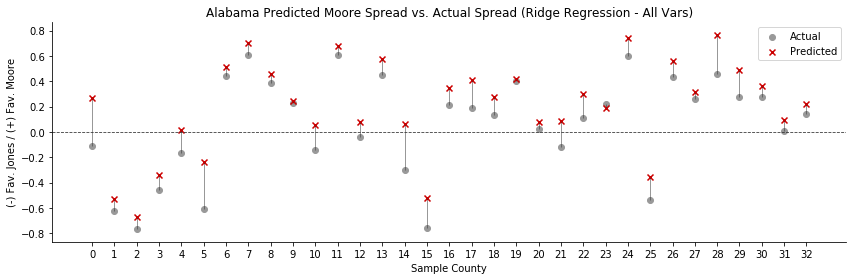

In [10]:
model = RidgeCV()

result = train_model(model, 
            model_name='Ridge Regression - All Vars',
            x_train=x_national_train, 
            y_train=y_national_train, 
            x_val=x_national_val, 
            y_val=y_national_val, 
            x_test=x_alabama_val, 
            y_test=y_alabama_val)

model_scores.append(result)

5-fold CV MSE Value | Train: 0.0180 | Validation: 0.0197 | Test: 0.0116


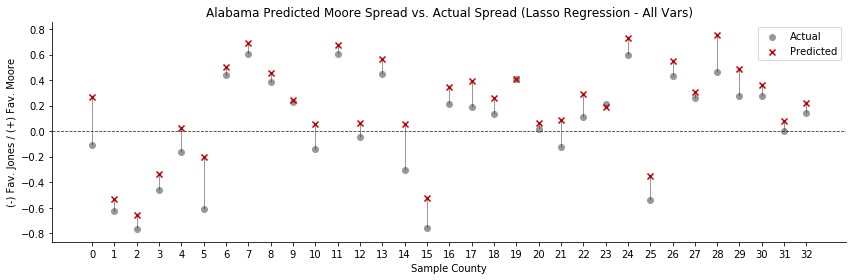

In [11]:
model = LassoCV(max_iter=5000)

result = train_model(model, 
            model_name='Lasso Regression - All Vars',
            x_train=x_national_train, 
            y_train=y_national_train, 
            x_val=x_national_val, 
            y_val=y_national_val, 
            x_test=x_alabama_val, 
            y_test=y_alabama_val)

model_scores.append(result)

5-fold CV MSE Value | Train: 0.0180 | Validation: 0.0196 | Test: 0.0118


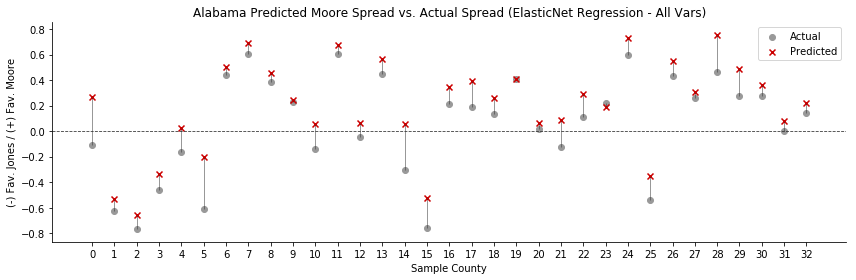

In [12]:
model = ElasticNetCV(max_iter=5000)

result = train_model(model, 
            model_name='ElasticNet Regression - All Vars',
            x_train=x_national_train, 
            y_train=y_national_train, 
            x_val=x_national_val, 
            y_val=y_national_val, 
            x_test=x_alabama_val, 
            y_test=y_alabama_val)

model_scores.append(result)

5-fold CV MSE Value | Train: 0.0180 | Validation: 0.0199 | Test: 0.0137


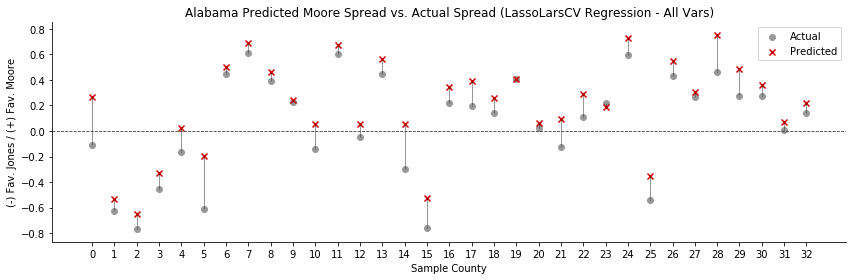

In [13]:
model = LassoLarsCV(max_iter=5000)

result = train_model(model, 
            model_name='LassoLarsCV Regression - All Vars',
            x_train=x_national_train, 
            y_train=y_national_train, 
            x_val=x_national_val, 
            y_val=y_national_val, 
            x_test=x_alabama_val, 
            y_test=y_alabama_val)

model_scores.append(result)

# Support Vector Regression

5-fold CV MSE Value | Train: 0.0197 | Validation: 0.0249 | Test: 0.0163


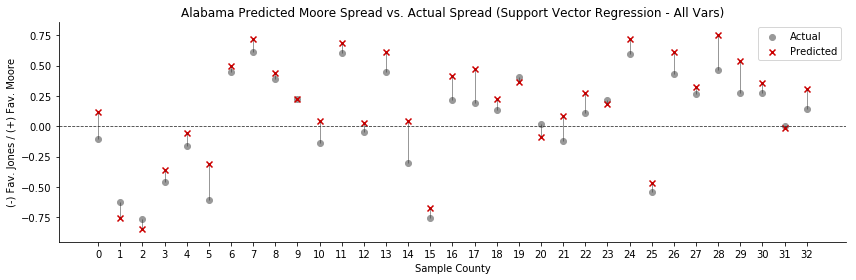

In [14]:
model = LinearSVR()

result = train_model(model, 
            model_name='Support Vector Regression - All Vars',
            x_train=x_national_train, 
            y_train=y_national_train, 
            x_val=x_national_val, 
            y_val=y_national_val, 
            x_test=x_alabama_val, 
            y_test=y_alabama_val)

model_scores.append(result)

# XGBoost Simple

5-fold CV MSE Value | Train: 0.0172 | Validation: 0.0222 | Test: 0.0518


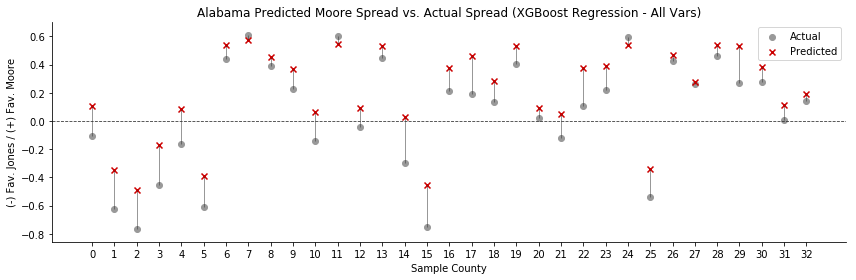

In [15]:
model = xgb.XGBRegressor(n_estimators=500, subsample=0.9, max_depth=4, min_child_weight=3,
                         gamma=0.1, colsample_bytree=0.9, reg_alpha=0.1, learning_rate=0.01,
                         eval_metric='rmse')

result = train_model(model, 
            model_name='XGBoost Regression - All Vars',
            x_train=x_national_train, 
            y_train=y_national_train, 
            x_val=x_national_val, 
            y_val=y_national_val, 
            x_test=x_alabama_val, 
            y_test=y_alabama_val)

model_scores.append(result)

# Show top features
There are obviously many correlated and redundant features in the data. For example, the % of people attending higher education is inversely related to those without advanced degrees since each bucket is mutually exclusive. Using the XGBoost model we'll choose the top 20 features from the data sorted by their importance in the model.

We choose the top 20 using their position in the original data. For the remaining fields, we try collectively representing them as PCA components

In [16]:
top_feat = sorted(zip(model.feature_importances_, feat_names), key=lambda x: -x[0])[:20]
top_feat_cols = [i for i,c in enumerate(feat_names) for imp,feat in top_feat if c in feat]
print('Top 20 Features')
print('\n'.join(['{:>20}: {:.3f}'.format(v,i) for i,v in top_feat]))

Top 20 Features
           RaceWhite: 0.106
            FamilyHH: 0.056
           RaceBlack: 0.048
         PopHispanic: 0.048
       InsuranceNone: 0.047
    IndustryAgMining: 0.039
 LanguageEnglishOnly: 0.038
  IncomePublicAssist: 0.033
         EduGraduate: 0.032
        EduAssociate: 0.022
             TotalHH: 0.021
       IndustryEnter: 0.021
      LaborUnempRate: 0.021
 IndustryManufacture: 0.020
     InsurancePublic: 0.020
        BornNativeUS: 0.018
      PayrollSelfEmp: 0.017
               EduHS: 0.017
IndustryProfessional: 0.016
      EduSomeCollege: 0.015


In [17]:
def get_decomposed(data, top_cols, n_components):
    not_top = [i for i in range(0, data.shape[1]) if not i in top_cols]
    arr = PCA(n_components=n_components).fit_transform(data[:, not_top])
    return np.concatenate([data[:, top_cols], arr], axis=1)

n_components = 10

x_national_train_d = get_decomposed(x_national_train, top_feat_cols, n_components)
x_national_val_d = get_decomposed(x_national_val, top_feat_cols, n_components)
x_alabama_val_d = get_decomposed(x_alabama_val, top_feat_cols, n_components)

# Train Linear Model - Reduced Varibles

5-fold CV MSE Value | Train: 0.0217 | Validation: 0.0221 | Test: 0.0182


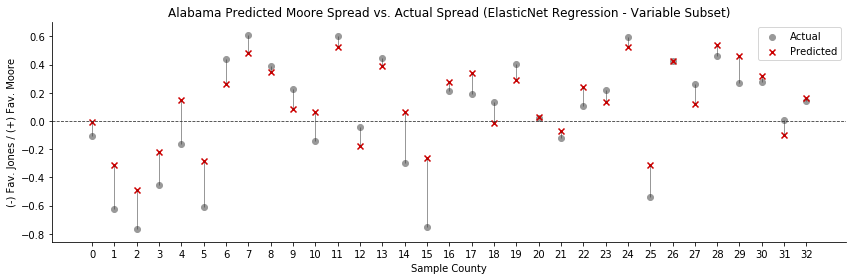

In [18]:
model = ElasticNetCV(max_iter=5000)

result = train_model(model, 
            model_name='ElasticNet Regression - Variable Subset',
            x_train=x_national_train_d, 
            y_train=y_national_train, 
            x_val=x_national_val_d, 
            y_val=y_national_val, 
            x_test=x_alabama_val_d, 
            y_test=y_alabama_val)

model_scores.append(result)

5-fold CV MSE Value | Train: 0.0217 | Validation: 0.0222 | Test: 0.0154


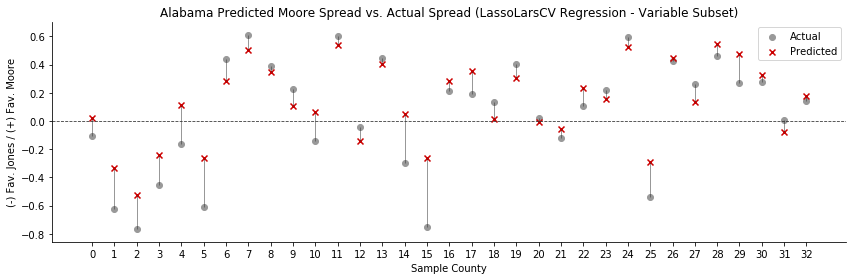

In [19]:
model = LassoLarsCV(max_iter=5000)

result = train_model(model, 
            model_name='LassoLarsCV Regression - Variable Subset',
            x_train=x_national_train_d, 
            y_train=y_national_train, 
            x_val=x_national_val_d, 
            y_val=y_national_val, 
            x_test=x_alabama_val_d, 
            y_test=y_alabama_val)

model_scores.append(result)

5-fold CV MSE Value | Train: 0.0217 | Validation: 0.0220 | Test: 0.0249


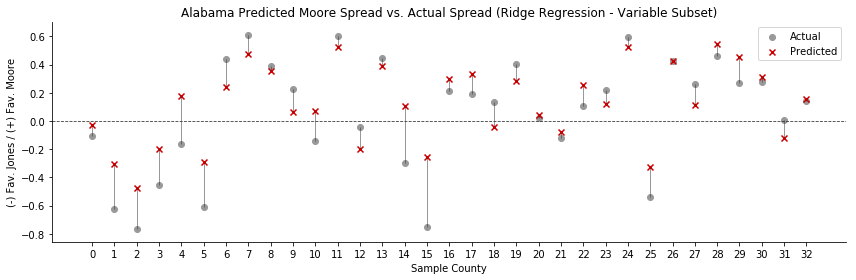

In [20]:
model = RidgeCV()

result = train_model(model, 
            model_name='Ridge Regression - Variable Subset',
            x_train=x_national_train_d, 
            y_train=y_national_train, 
            x_val=x_national_val_d, 
            y_val=y_national_val, 
            x_test=x_alabama_val_d, 
            y_test=y_alabama_val)

model_scores.append(result)

5-fold CV MSE Value | Train: 0.0217 | Validation: 0.0221 | Test: 0.0167


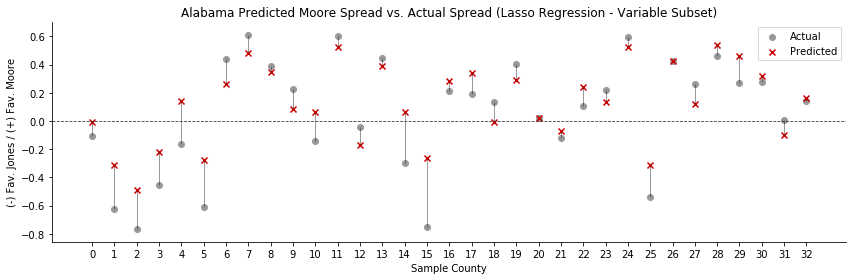

In [21]:
model = LassoCV(max_iter=5000)

result = train_model(model, 
            model_name='Lasso Regression - Variable Subset',
            x_train=x_national_train_d, 
            y_train=y_national_train, 
            x_val=x_national_val_d, 
            y_val=y_national_val, 
            x_test=x_alabama_val_d, 
            y_test=y_alabama_val)

model_scores.append(result)

# XGBoost - Reduced Variables

5-fold CV MSE Value | Train: 0.0173 | Validation: 0.0220 | Test: 0.0374


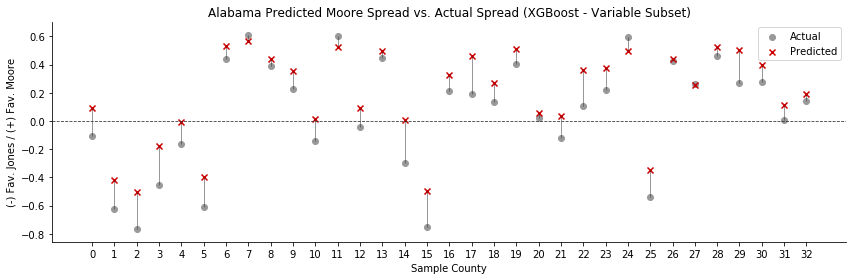

In [22]:
model = xgb.XGBRegressor(n_estimators=500, subsample=0.9, max_depth=4, min_child_weight=3,
                         gamma=0.1, colsample_bytree=0.9, reg_alpha=0.1, learning_rate=0.01,
                         eval_metric='rmse')

result = train_model(model, 
            model_name='XGBoost - Variable Subset',
            x_train=x_national_train_d, 
            y_train=y_national_train, 
            x_val=x_national_val_d, 
            y_val=y_national_val, 
            x_test=x_alabama_val_d, 
            y_test=y_alabama_val)

model_scores.append(result)

# Going Deeper

Lets try using a neural network to perform regression and see whether we get better results. We're going to use the Keras API on a three layer network to perform regression. Each layer has some dropout and batch normalization applied. We also use early stopping to prevent the network from going too far in the wrong direction.

In [23]:
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

es = EarlyStopping(monitor='val_mean_squared_error',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')

alpha = 0.1

model = Sequential()
model.add(Dense(512, input_dim=91))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(optimizer=Adam(lr=0.004, decay=0.0001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

model.fit(x_national_train, y_national_train, epochs=50, batch_size=256, callbacks=[es],
          validation_data=(x_alabama_val, y_alabama_val))


Using TensorFlow backend.


Train on 2128 samples, validate on 33 samples
Epoch 1/50
2128/2128 [==============================] - 1s 410us/step - loss: 2.1383 - mean_squared_error: 2.1383 - val_loss: 0.7764 - val_mean_squared_error: 0.7764
Epoch 2/50
2128/2128 [==============================] - 0s 59us/step - loss: 0.3449 - mean_squared_error: 0.3449 - val_loss: 0.2322 - val_mean_squared_error: 0.2322
Epoch 3/50
2128/2128 [==============================] - 0s 60us/step - loss: 0.2464 - mean_squared_error: 0.2464 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 4/50
2128/2128 [==============================] - 0s 58us/step - loss: 0.1913 - mean_squared_error: 0.1913 - val_loss: 0.0822 - val_mean_squared_error: 0.0822
Epoch 5/50
2128/2128 [==============================] - 0s 57us/step - loss: 0.1676 - mean_squared_error: 0.1676 - val_loss: 0.0399 - val_mean_squared_error: 0.0399
Epoch 6/50
2128/2128 [==============================] - 0s 57us/step - loss: 0.1433 - mean_squared_error: 0.1433 - val_loss: 0.0

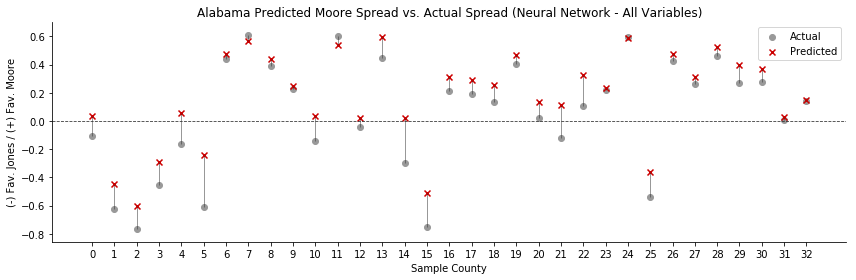

In [24]:
def evalulate_keras(model, model_name, x, y):
    scores = []
    for train_index, test_index in KFold(5).split(x_alabama_val, y_alabama_val):
        y_pred = model.predict(x_alabama_val[train_index])
        scores.append(mean_squared_error(y_alabama_val[train_index], y_pred))
    return {'name': model_name, 'train': np.nan, 'validation': np.nan, 'test': np.array(scores).mean()}

plot_results(model.predict(x_alabama_val), x_alabama_val, y_alabama_val, 'Neural Network - All Variables')

result = evalulate_keras(model, 
                model_name='Neural Network - All Variables',
                x=x_alabama_val, 
                y=y_alabama_val)

model_scores.append(result)

# Final Model Comparison
I'm a little surprised at the performance of simple linear regression over more complex algorithms. Therefore I think there's lots of room to improve this excercise further through feature engineering and better hyperparamter tuning. Overall, it seems that having more variables is better than limiting to the top 20.

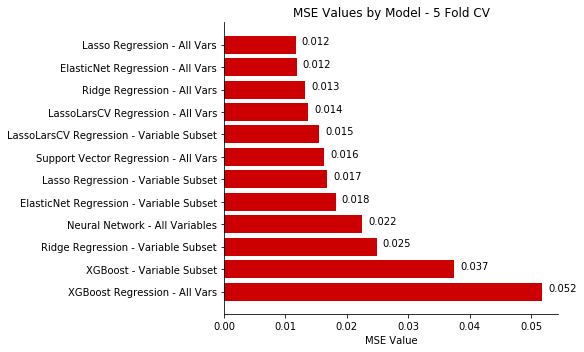

In [25]:
def plot_all(model_scores):
    df = pd.DataFrame(model_scores).sort_values(by='test', ascending=False).set_index('name')
    
    f, ax = plt.subplots(1, 1, figsize=(8,5))
    
    for i,d in enumerate(df.iterrows()):
        ax.barh(i, d[1].test, color='#CC0000')
        ax.text(d[1].test + 0.001, i, '{:.3f}'.format(d[1].test))
    
    ax.set_yticklabels(df.index.values)
    ax.set_yticks(range(0, len(df.index)))
    plt.title('MSE Values by Model - 5 Fold CV')
    plt.xlabel('MSE Value')
    plt.ylabel('')
    sb.despine()
    plt.tight_layout()
    
plot_all(model_scores)

# Observation
An obverservation is that the distribution of scores between the two groups is not identical. When we look at the 2016 election results, the data was skewed quite a bit beyond what the 2017 Alabama race actually was. If you look at the outputs from some of the models, it seems their predictions were also offset by similar amounts. 

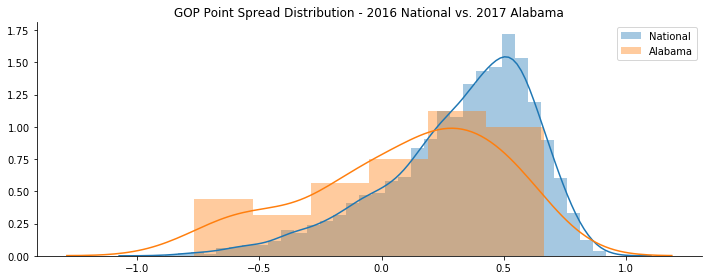

In [26]:
def plot_distributions(y_alabama, y_national):
    plt.subplots(1, 1, figsize=(10,4))
    sb.distplot(y_national, label='National')
    sb.distplot(y_alabama, label='Alabama')
    plt.legend()
    plt.title('GOP Point Spread Distribution - 2016 National vs. 2017 Alabama')
    sb.despine()
    plt.tight_layout()
    
plot_distributions(y_alabama, y_national)